<div style="text-align: center;">
    <h1>Improving Sentiment Analysis on Imbalanced Data</h1>
</div>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk                                                                       # Part 1
import re                                                                         # Part 1
from nltk.corpus import stopwords                                                 # Part 1
from nltk.stem import WordNetLemmatizer                                           # Part 1
from nltk.corpus import wordnet                                                   # Part 1
from nltk.tokenize import word_tokenize                                           # Part 1
from sklearn.feature_extraction.text import TfidfVectorizer                       # Part 2
from sklearn.model_selection import train_test_split                              # Part 2
from sklearn.linear_model import LogisticRegression                               # Part 3
from sklearn.metrics import accuracy_score, f1_score, classification_report, auc  # Part 3
from sklearn.metrics import precision_recall_curve, precision_score, recall_score # Part 3
import random                                                                     # Part 5
from itertools import product                                                     # Part 5
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay              # Part 6

## 1. Text Preprocessing

In [5]:
data = pd.read_csv('amazon_alexa.tsv', sep='\t')
data = data[['verified_reviews', 'feedback']]
data = data.dropna()

In [6]:
# Defining lexical mapping functions to improve the accuracy of word form reduction
def get_wordnet_pos(word):
    """Returns the lexical properties of words for more precise morphological reduction"""
    tag = nltk.pos_tag([word])[0][1][0].upper()                         # nltk.pos_tag: to lexically label each word in a sentence
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)                              # Treated as a noun by default if non-matched
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))   # No stop_words like, eg:a the is in he there often been nor none
    negation_words = {"no", "not", "none", "nor", "never", "n't"}
    stop_words = stop_words - negation_words       # new-defined stop word exclude negative words
    text = re.sub(r'[^\w\s]', '', text)            # No Letters, Numbers, Underscores, or Space ------ Punctuation is deleted, too
    text = text.lower()                            # Lower
    words = word_tokenize(text)                    # Tokenize
    words = [word for word in words if word not in stop_words]   # Remove stop words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(words)                         # Recombine the processed list of words into a string
data['processed_reviews'] = data['verified_reviews'].apply(preprocess_text)

## 2. Feature extraction using TF-IDF + dataset partitioning + Random Oversampling

#### TF-IDF

In [9]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)  # Extract single and double words (unigram + bigram)
X = tfidf_vectorizer.fit_transform(data['processed_reviews'])              # Use processed_reviews as feature
y = data['feedback']                                                       # Feedback as target

#### Dataset Partitioning

In [11]:
X = X.toarray()                       # Small datasets, toarray() is fine. Big: use X.shape[0] instead of len(X) in permutation
y = np.array(y)
np.random.seed(39)
indices = np.random.permutation(len(X))          # Generate random indexes / Shuffle the dataset
split_index = int(len(X) * 0.8)                  # 80 - 20
X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]

#### Random Oversampling

In [13]:
positive_class_count = np.sum(y_train == 1)
negative_class_count = np.sum(y_train == 0)
target_negative_count = int(positive_class_count / 2)
if negative_class_count < target_negative_count:
    negative_indices = np.where(y_train == 0)[0]                               # Index of all negative class samples
    additional_negative_count = target_negative_count - negative_class_count   # num of additional neg class samples to be added
    additional_negative_indices = np.random.choice(negative_indices, size=additional_negative_count, replace=True) # random select neg
    # Add the oversampled negative class samples to the training set
    X_train_resampled = np.concatenate((X_train, X_train[additional_negative_indices]), axis=0)
    y_train_resampled = np.concatenate((y_train, y_train[additional_negative_indices]), axis=0)
else:
    X_train_resampled = X_train
    y_train_resampled = y_train
print("Original category distribution:", np.bincount(y_train))
print("After oversampling:", np.bincount(y_train_resampled))

Original category distribution: [ 205 2314]
After oversampling: [1157 2314]


## 3. Basic Logistics Regression

In [15]:
def sigma(z):
	return 1 / (1 + np.exp(-z))

# I tried the Focal Loss after office hours, but I found "Focal Loss" performs not better than "Oversampling + normal cost function".
# Thus, I changed to my original normal cost function.
def compute_cost(y, y_pred):
	m = y.shape[0]
	y_pred = np.clip(y_pred, 1e-10, 1-1e-10)
	cost = -(1/m) * np.sum(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred))
	return cost

def gradient_descent(X, y, learning_rate=0.01, epochs=1000, verbose=True):
	n_samples, n_features = X.shape
	w = np.zeros(n_features)
	b = 0
	cost_history = []
	for epoch in range(epochs):
		z = np.dot(X, w) + b
		y_pred = sigma(z)
		error = y_pred - y
		dw = (1 / n_samples) * np.dot(X.T, error)
		db = (1 / n_samples) * np.sum(error)
		w -= learning_rate * dw
		b -= learning_rate * db
		cost = compute_cost(y, y_pred)
		cost_history.append(cost)
		if verbose and (epoch % 100 == 0):
			print(f'Epoch {epoch}: Cost {cost}')
	return w, b, cost_history
    
def predict(X, w, b):
	z = np.dot(X, w) + b
	y_pred = sigma(z)
	return (y_pred >= 0.5).astype(int)

In [16]:
print("Positive class in y_test:", np.sum(y_test == 1))
print("Negative class in y_test:", np.sum(y_test == 0))

Positive class in y_test: 579
Negative class in y_test: 51


In [17]:
learning_rate = 0.05
epochs = 5000
w, b, cost_history = gradient_descent(X_train_resampled, y_train_resampled, learning_rate=learning_rate, epochs=epochs, verbose=False)
y_test_base_pred = predict(X_test, w, b)

In [18]:
def evaluate_model_with_sklearn(y_test, y_pred):
    # Precision, Recall, F1 for positive class
    precision_positive = precision_score(y_test, y_pred, pos_label=1)
    recall_positive = recall_score(y_test, y_pred, pos_label=1)
    f1_positive = f1_score(y_test, y_pred, pos_label=1)
    
    # Precision, Recall, F1 for negative class
    precision_negative = precision_score(y_test, y_pred, pos_label=0)
    recall_negative = recall_score(y_test, y_pred, pos_label=0)
    f1_negative = f1_score(y_test, y_pred, pos_label=0)
    
    # Weighted F1 Score
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Positive Class - Precision: {precision_positive:.4f}, Recall: {recall_positive:.4f}, F1 Score: {f1_positive:.4f}")
    print(f"Negative Class - Precision: {precision_negative:.4f}, Recall: {recall_negative:.4f}, F1 Score: {f1_negative:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")

    return weighted_f1
    
evaluate_model_with_sklearn(y_test, y_test_base_pred)

Positive Class - Precision: 0.9249, Recall: 1.0000, F1 Score: 0.9610
Negative Class - Precision: 1.0000, Recall: 0.0784, F1 Score: 0.1455
Weighted F1 Score: 0.8950


0.8949758402040559

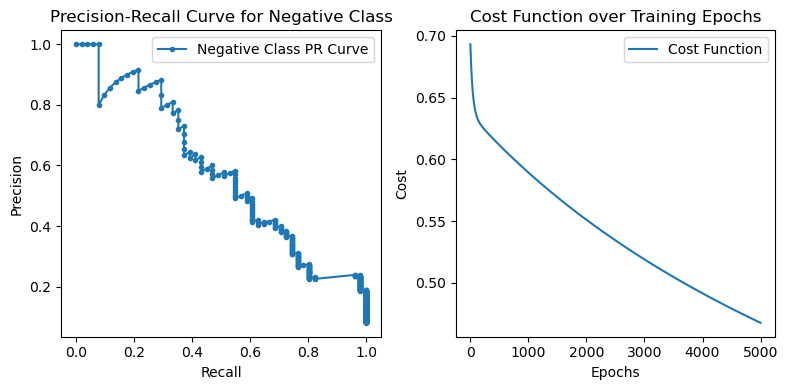

Area Under Precision-Recall Curve (Negative Class): 0.5777


In [19]:
y_test_reversed = 1 - y_test                        # negative; Reverse the labels
y_pred_proba = sigma(np.dot(X_test, w) + b)
y_pred_proba_reversed = 1 - y_pred_proba            # negative class prob
precision_neg, recall_neg, thresholds_neg = precision_recall_curve(y_test_reversed, y_pred_proba_reversed)

plt.figure(figsize=(8, 4))

# Left: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_neg, precision_neg, marker='.', label='Negative Class PR Curve')
plt.title('Precision-Recall Curve for Negative Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# Right: Cost Function Curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), cost_history, label='Cost Function')
plt.title('Cost Function over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.tight_layout()
plt.show()

# AUC for Negative Class
auc_pr_neg = auc(recall_neg, precision_neg)
print(f"Area Under Precision-Recall Curve (Negative Class): {auc_pr_neg:.4f}")

**Comment:** The negative class has a recall of 0.0784 and an F1 score of 0.1455, indicating that the baseline model struggles to distinguish the negative class effectively. Additionally, the area under the precision-recall curve (AUC-PR) for the negative class is 0.5777, which is also poor. These metrics suggest that the baseline model performs poorly on the negative class, almost resembling random predictions. To address this, I will implement an improved logistic regression model with L1 and L2 regularization, combined with random search and grid search optimization techniques to enhance the model's performance.

## 4. Elastic Net Logistics Regression (L1 to select features and L2 to control complexity)

In [22]:
def sigma(z):
	return 1 / (1 + np.exp(-z))
def compute_cost_with_elastic_net(y, y_pred, w, alpha=0.1, l1_ratio=0.1):
    m = y.shape[0]
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    cost = -(1 / m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    l1_penalty = l1_ratio * alpha * np.sum(np.abs(w))
    l2_penalty = (1 - l1_ratio) * alpha * np.sum(np.square(w))
    return cost + (l1_penalty + l2_penalty) / m
def gradient_descent_elastic_net(X, y, learning_rate=0.01, epochs=2000, alpha=0.1, l1_ratio=0.1, verbose=True):
    n_samples, n_features = X.shape
    w = np.random.randn(n_features) * 0.01
    b = 0
    cost_history = []
    for epoch in range(epochs):
        z = np.dot(X, w) + b
        y_pred = sigma(z)
        error = y_pred - y
        dw = (1 / n_samples) * np.dot(X.T, error)
        db = (1 / n_samples) * np.sum(error)
        dw += (l1_ratio * alpha / n_samples) * np.sign(w)
        dw += ((1 - l1_ratio) * alpha * 2 / n_samples) * w
        w -= learning_rate * dw
        b -= learning_rate * db
        cost = compute_cost_with_elastic_net(y, y_pred, w, alpha, l1_ratio)
        cost_history.append(cost)
        if verbose and (epoch % 100 == 0):
            print(f'Epoch {epoch}: Cost {cost}')
    return w, b, cost_history
def predict_elastic_net(X, w, b):
	z = np.dot(X, w) + b
	y_pred = sigma(z)
	return (y_pred >= 0.5).astype(int)

## 5. optimization (Random Search + Grid Search)

#### Random Search

In [31]:
learning_rates = [1.1, 1.3, 1.4, 1.5, 1.8]
alphas = [0.05, 0.1, 0.2, 0.3, 0.4]
l1_ratios = [0.6, 0.7, 0.8, 0.9]

best_params = None
best_f1_score = 0 

for i in range(50): 
    learning_rate = random.choice(learning_rates)
    alpha = random.choice(alphas)
    l1_ratio = random.choice(l1_ratios)
    print(f"--Now trying：LR={learning_rate}, Alpha={alpha}, L1_ratio={l1_ratio}")

    w, b, _ = gradient_descent_elastic_net(X_train_resampled, y_train_resampled, 
                                           learning_rate=learning_rate, epochs=5000, 
                                           alpha=alpha, l1_ratio=l1_ratio, verbose=False)

    y_test_pred = predict_elastic_net(X_test, w, b)
    weighted_f1_score = evaluate_model_with_sklearn(y_test, y_test_pred)

    if weighted_f1_score > best_f1_score:
        best_f1_score = weighted_f1_score
        best_params = (learning_rate, alpha, l1_ratio)
        print(f"New Best Params: LR={learning_rate}, Alpha={alpha}, L1_ratio={l1_ratio}, F1={best_f1_score:.4f}")

print(f"\nBest Random Search Parameters: {best_params} with F1 Score: {best_f1_score}")

--Now trying：LR=1.3, Alpha=0.4, L1_ratio=0.7
Positive Class - Precision: 0.9593, Recall: 0.9775, F1 Score: 0.9683
Negative Class - Precision: 0.6750, Recall: 0.5294, F1 Score: 0.5934
Weighted F1 Score: 0.9380
New Best Params: LR=1.3, Alpha=0.4, L1_ratio=0.7, F1=0.9380
--Now trying：LR=1.4, Alpha=0.1, L1_ratio=0.7
Positive Class - Precision: 0.9627, Recall: 0.9810, F1 Score: 0.9718
Negative Class - Precision: 0.7250, Recall: 0.5686, F1 Score: 0.6374
Weighted F1 Score: 0.9447
New Best Params: LR=1.4, Alpha=0.1, L1_ratio=0.7, F1=0.9447
--Now trying：LR=1.1, Alpha=0.3, L1_ratio=0.8
Positive Class - Precision: 0.9626, Recall: 0.9793, F1 Score: 0.9709
Negative Class - Precision: 0.7073, Recall: 0.5686, F1 Score: 0.6304
Weighted F1 Score: 0.9433
--Now trying：LR=1.8, Alpha=0.05, L1_ratio=0.6
Positive Class - Precision: 0.9579, Recall: 0.9827, F1 Score: 0.9702
Negative Class - Precision: 0.7222, Recall: 0.5098, F1 Score: 0.5977
Weighted F1 Score: 0.9400
--Now trying：LR=1.1, Alpha=0.05, L1_ratio=0

#### Grid Search

In [35]:
learning_rates = [1.4, 1.5, 1.6]
alphas = [0.15, 0.2, 0.25]
l1_ratios = [0.5, 0.6, 0.7]
epochs = 5000

best_f1_score = 0
best_params = None

for learning_rate in learning_rates:
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            w, b, _ = gradient_descent_elastic_net(X_train_resampled, y_train_resampled, 
                                                   learning_rate=learning_rate, epochs=epochs, 
                                                   alpha=alpha, l1_ratio=l1_ratio, verbose=False)
            y_test_pred = predict(X_test, w, b)
            weighted_f1_score = evaluate_model_with_sklearn(y_test, y_test_pred)

            if weighted_f1_score > best_f1_score:
                best_f1_score = weighted_f1_score
                best_params = (learning_rate, alpha, l1_ratio)
                print(f"New Best Params: LR={learning_rate}, Alpha={alpha}, L1_ratio={l1_ratio}, F1={best_f1_score}")

print(f"\nBest Grid Search Parameters: LR={best_params[0]}, Alpha={best_params[1]}, L1_ratio={best_params[2]}, F1={best_f1_score}")

Positive Class - Precision: 0.9628, Recall: 0.9827, F1 Score: 0.9726
Negative Class - Precision: 0.7436, Recall: 0.5686, F1 Score: 0.6444
Weighted F1 Score: 0.9461
New Best Params: LR=1.4, Alpha=0.15, L1_ratio=0.5, F1=0.9460805860805861
Positive Class - Precision: 0.9628, Recall: 0.9827, F1 Score: 0.9726
Negative Class - Precision: 0.7436, Recall: 0.5686, F1 Score: 0.6444
Weighted F1 Score: 0.9461
Positive Class - Precision: 0.9628, Recall: 0.9827, F1 Score: 0.9726
Negative Class - Precision: 0.7436, Recall: 0.5686, F1 Score: 0.6444
Weighted F1 Score: 0.9461
Positive Class - Precision: 0.9628, Recall: 0.9827, F1 Score: 0.9726
Negative Class - Precision: 0.7436, Recall: 0.5686, F1 Score: 0.6444
Weighted F1 Score: 0.9461
Positive Class - Precision: 0.9628, Recall: 0.9827, F1 Score: 0.9726
Negative Class - Precision: 0.7436, Recall: 0.5686, F1 Score: 0.6444
Weighted F1 Score: 0.9461
Positive Class - Precision: 0.9627, Recall: 0.9810, F1 Score: 0.9718
Negative Class - Precision: 0.7250, Re

**Comment:** (1.4, 0.15, 0.5) is the best parameter combinations after grid search.

In [47]:
learning_rate = 1.4
alpha = 0.15
l1_ratio = 0.5
epochs = 5000
e_w, e_b, elastic_net_cost_function = gradient_descent_elastic_net(X_train_resampled, y_train_resampled, learning_rate, 
                                                                   epochs, alpha=alpha, l1_ratio=l1_ratio, verbose=False)
y_test_improved_pred = predict(X_test, w, b)

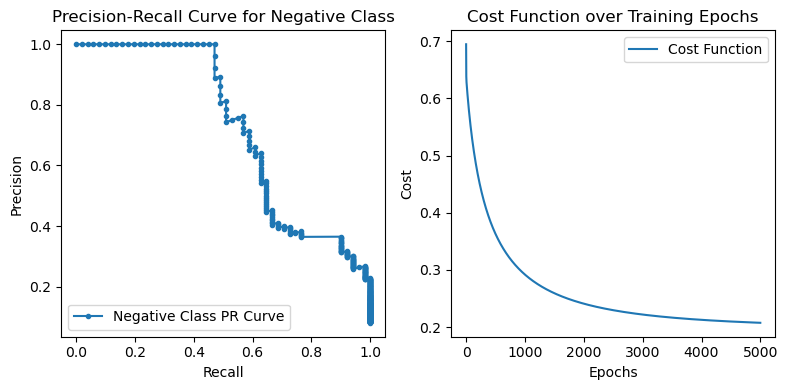

Area Under Precision-Recall Curve (Negative Class): 0.7223


In [49]:
y_test_reversed = 1 - y_test
y_test_pred = sigma(np.dot(X_test, e_w) + e_b)
y_pred_proba_reversed = 1 - y_test_pred              # For the Negative Class
precision_neg, recall_neg, thresholds_neg = precision_recall_curve(y_test_reversed, y_pred_proba_reversed)

plt.figure(figsize=(8, 4))

# Left: Precision-Recall Curve for Negative Class
plt.subplot(1, 2, 1)
plt.plot(recall_neg, precision_neg, marker='.', label='Negative Class PR Curve')
plt.title('Precision-Recall Curve for Negative Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# Right: Cost Function over Training Epochs
plt.subplot(1, 2, 2)
plt.plot(range(epochs), elastic_net_cost_function, label='Cost Function')
plt.title('Cost Function over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.tight_layout()
plt.show()

auc_pr_neg = auc(recall_neg, precision_neg)
print(f"Area Under Precision-Recall Curve (Negative Class): {auc_pr_neg:.4f}")

**Comment:** After analyzing and searching examples on the Internet, I found the 0.7223 of Area Under Precision-Recall Curve (AUPRC) is a good enough for for logistic regression, especially for this more than 1:11 imbalanced datasets. Moreover, the cost function figure on the right is fine, too.

## 6. Visualization - Confusion Matrix

Besides comparisons of (1) Precision-Recall Curve for Negative Class, and (2) Cost function plot I have plotted before, I would like to add a confusion matrix visulization in the end.

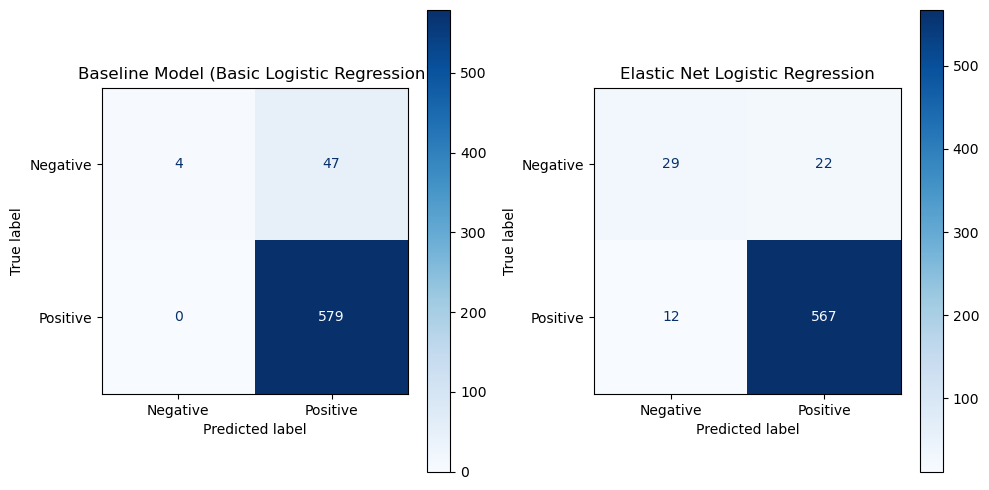

In [52]:
# Baseline Logistic Regression Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_test_base_pred)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=['Negative', 'Positive'])

# Improved Logistic Regression Confusion Matrix
cm_elastic_net = confusion_matrix(y_test, y_test_improved_pred) 
disp_elastic_net = ConfusionMatrixDisplay(confusion_matrix=cm_elastic_net, display_labels=['Negative', 'Positive'])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left
disp_baseline.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='d')
axes[0].set_title("Baseline Model (Basic Logistic Regression)")

# Right
disp_elastic_net.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='d')
axes[1].set_title("Elastic Net Logistic Regression")

plt.tight_layout()
plt.show()

**Comment:** The confusion matrix illustrates that after applying L1 and L2 regularization, the logistic regression model performs significantly better on the negative class, while the performance on the positive class remains similar to the baseline model. The combination of L1 for feature selection and L2 for controlling model complexity has demonstrated a substantial improvement in overall performance, as shown in this project.

**Future Directions:** For future improvements beyond this project, I would consider: 1) applying PCA to more effectively reduce dimensionality; 2) using techniques like SMOTE or ADASYN to generate balanced synthetic samples; and 3) exploring advanced models such as SVM, XGBoost, Random Forest, and others.